# Convolutional Neural Networks for Classification Based on Soundwave Structure

## Notebook Structure:
1. Library Imports 
2. Project Inspiration and Goal
3. Exploratory Data Analysis
4. Data Cleaning and Data Storage Design
5. Model Design
6. Optimizer Selection
7. Training
8. Analysis
9. Conclusion
10. Future Work and Model Relevance
11. References

# Library Imports

In [1]:
import numpy as np
import pandas as pd
import torchaudio
import IPython
import seaborn as sns
import math
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [9]:
# Check if GPU is available, I use Pytorch because Tensorflow has an issue recognizing my GPU...
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Project Inspiration and Goal:

## Nanopore Sequencing
DNA and RNA sequencing has seen a recent rise in a technology called nanopore sequencing. The nanopore uses a an electrical current coupled with a very small performation in a film to measure current fluctation as DNA or RNA strands pass through the nanopore. This technology has allowed for extraordinarily long reads in comparisson to its contemporaries. One of the unique challenges of nanopore sequencing is turning the output data into a sequence of DNA or RNA nucleotides. This process is known as basecalling and relies heavily on hidden markov models and recurrent neural networks.

### Overview of Nanopore Sequencing
![Random Unsplash Image](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.researchgate.net%2Fprofile%2FAnton_Henssen%2Fpublication%2F346026569%2Ffigure%2Ffig5%2FAS%3A963962795458577%401606838048670%2FNanopore-sequencing-characterizes-DNA-methylation-on-MYCN-amplicons-a-Schematic-of.png&f=1&nofb=1)
ResearchGate: https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.researchgate.net%2Fprofile%2FAnton_Henssen%2Fpublication%2F346026569%2Ffigure%2Ffig5%2FAS%3A963962795458577%401606838048670%2FNanopore-sequencing-characterizes-DNA-methylation-on-MYCN-amplicons-a-Schematic-of.png&f=1&nofb=1

## Nanopore Data
The data that nanopore sequencing produces shares a number of qualities with audio data produced by a microphone or other audio capturing device. Both are composed of multiple sources of input coalescing into a single waveform, this in turn leads to complex final forms composed of simpler components.
### Nanopore Sequencing Ionic Current Data with Biological Context
![Random Unsplash Image](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%3Fid%3DOIP.bw3zcf8Zw_uThslJDPnS5QHaGw%26pid%3DApi&f=1)
Washington.edu: https://www.washington.edu/news/2013/10/15/nanopore-sequencing-technology-lands-licensing-deal/



## Parallel with Audio Data
Below we can see that the nanopore sequencing structure shares somse commonality with the audio waveform data. Different segments of frequency are combined to form the larger pattern. Because of this commonality the hope is that speech to text recognition techniques, which have been the subject of extensive research during the last 5 years, will be a good jumping off point for more nuanced nanopore basecalling. 
![Random Unsplash Image](http://www.assap.ac.uk/newsite/Pics/Let.jpg)
ASSAP: http://www.assap.ac.uk/newsite/Pics/Let.jpg

## Using Speech Recognition Techniques for Classifying Nanopore Data
One of the complications of nanopore data is that the ionic current doesn't measure just one nucleotide at a time, which would reduce the difficulty of classification. Nor for that matter do the nucleotides move through the nanopore at the same rate, further complicating the process of turing ionic current into nucleotide sequence. But these difficulties in nanopore current translation have parallels in speech to text techniques. For instance speech to text software needs to differentiate between audio clips that use different cadences to deliver a word, even though one may be twice as long as the other, both are saying the same word. Similarly, different combinations of component units (letters for speech to text) having entirely unique wave forms is not a new phenomenon. The letters c and h have distinct sounds from each other, and similarly the letters ch in unison are different from both c and h. The hope is that this project will be a step in showing that nanopore sequencing can benefit from the same strategies.

## Refining speech recognition techniques to help identify modifications in tRNA
The overarching idea is that if we can find an ideal slice size for nanopore ionic current data, and train a model to recognize the unique wave form identity of a nanopore sequence, stepping one slice at a time to reconstruct accurate sequences. The benefit of this goal would be that with time training data sets could begin to include modifications present in DNA and RNA that otherwise do not generally get labeled during base calling. These modifications often have impacts on the ways RNAs fold and interact with one another, which raises the question what biological implications might these modifications have? The first step will be finding a way to reliably identify those modifications.

## Project Goal
This step of the over arching process will focus on identifying the viability of classifying high-quality audio samples through the use of spectrograms and a two-layer convolutional neural network. The test case that will bear the most weight moving forward will be testing if the model is capable of classifying the audio files from speakers who it has never heard before. This will serve as a proof of parallel concept to the environmental conditions that may alter nanopore read data in pervasive ways such as ambient current, electrode sensitivity, and other factors that can't always be controlled.

# Exploratory Data Analysis

The data for this project was collected from kaggle at the following URL: https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist.

The Data consists of 60 speakers saying the letters 0-9 50 times per number. Each utterance is held in it's own .wav file and all of the files are less than 1 second in length. The total number of samples is 30000.

In [2]:
# Create Data Frame of file_paths and labels

In [3]:
root_path = "Audio_Data\\data"

In [4]:
file_paths = []
labels = []
speaker_id = []
for directory in os.listdir(root_path):
    if directory != "audioMNIST_meta.txt":
        directory_path = root_path + "\\" + directory
        for file in os.listdir(directory_path):
            file_paths.append(directory_path + "\\" + file)
            speaker = file[2:4]
            speaker_id.append(speaker)
            labels.append(int(file[0]))
df = pd.DataFrame()
df["audio_files"] = file_paths
df["labels"] = labels
df["speaker"] = speaker_id
df.head()

,audio_files,labels,speaker
0,Audio_Data\data\01\0_01_0.wav,0,01
1,Audio_Data\data\01\0_01_1.wav,0,01
2,Audio_Data\data\01\0_01_10.wav,0,01
3,Audio_Data\data\01\0_01_11.wav,0,01
4,Audio_Data\data\01\0_01_12.wav,0,01


We should see that for each of the 10 labels there are exactly 3000 samples.

(60 speakers * 50 samples / speaker = 3000 samples per label)

In [5]:
df["labels"].value_counts()

0    3000
1    3000
2    3000
3    3000
4    3000
5    3000
6    3000
7    3000
8    3000
9    3000
Name: labels, dtype: int64

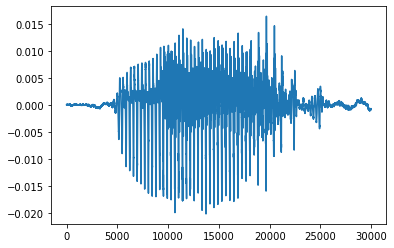

In [33]:
example_tensor = torchaudio.load("Audio_Data\\data\\01\\9_01_0.wav")
example_audio_file = example_tensor[0][0].numpy()
plt.plot(example_audio_file)

In [35]:
#Identify rate for audio file
print(example_tensor[1])

48000


In [7]:
IPython.display.Audio(example_audio_file, rate = 48000)

These audio files are very clean, have little "down time" where the speaker is not speaking, and contain minimal background noise. Essentially these are best case scenario's for audio data, if the model can't classify these it is an issue with the model not with the "cleanliness" of the data.

We need to identify the maximum tensor length, so that we can create a padded version in our data storage class. We need all of the input arrays to have the same length for our model to function properly

In [8]:
longest_audio_tensor = 0
for i in range(len(df)):
    x = torchaudio.load(df["audio_files"].values[i])
    if len(x[0][0]) > longest_audio_tensor:
        longest_audio_tensor = len(x[0][0])
print(longest_audio_tensor)

47998


# Data Cleaning and Data Storage Design

Pytorch requires a couple of things for our model to work properly and we will address them in this order:
 1. Object for holding the data
 2. Data loader
 3. Optimizer

## Splitting Data
We will focus on splitting the data into train, validation, test, and new speaker test sets. The reason we differentiate between test and new speaker test sets is that by withholding speakers from the entire training process will go to show how well our model can extrapolate for speakers it has never heard before. This is an important distinction when consider the application in the tRNA space because it means we will know if our models should be capable of making basecalls from experimental set ups and locations it was not trained on. Without that knowledge it would require each nanopore sequencing endeavour to train their own model from data they collect, which would introduce a significant amount of error into the experiment.

In [10]:
# Splitting Data in Train, Validate, Test, New Speaker sets
# Special dimensions of splitting, withhold 2 speakers from the Train Validate split. This will allow us to 
# test if unique speakers, unknown to our model test well.
random.seed(10)
unique_speakers = list(set(df["speaker"].values))
new_speaker_test = random.sample(unique_speakers, 3)
print(f"For our test speakers the model has not heard before we are going to use speakers: {new_speaker_test}.")

For our test speakers the model has not heard before we are going to use speakers: ['29', '07', '39'].


In [11]:
# Seperate out new_speaker_test df
new_speaker_index = df.index[(df["speaker"] == new_speaker_test[0]) | (df["speaker"] == new_speaker_test[1]) | (df["speaker"] == new_speaker_test[2])].tolist()
new_speaker_df = df.iloc[new_speaker_index]
print(new_speaker_df.head())
print(list(set(new_speaker_df["speaker"])))

#Remove these indicies from the original df
df.drop(index = new_speaker_index, inplace = True)
df.reset_index(inplace=True)
df.shape

                         audio_files  labels speaker
3000   Audio_Data\data\07\0_07_0.wav       0      07
3001   Audio_Data\data\07\0_07_1.wav       0      07
3002  Audio_Data\data\07\0_07_10.wav       0      07
3003  Audio_Data\data\07\0_07_11.wav       0      07
3004  Audio_Data\data\07\0_07_12.wav       0      07
['07', '39', '29']


(28500, 4)

In [12]:
# Assemble train, validate, and test with having heard speaker df's
shuffled_index = random.sample(df.index.tolist(), len(df.index) - 1)

In [13]:
# Test_proportion will be 0.1
# Train will be 0.7
# Validate will be 0.2

count_test = math.floor(0.1 * len(shuffled_index))
count_train = math.floor(0.7 * len(shuffled_index))
count_validate = len(shuffled_index) - count_test - count_train

test_index = shuffled_index[:count_test]
train_index = shuffled_index[count_test:count_test + count_train]
validate_index = shuffled_index[count_train + count_test:]

assert len(test_index) == count_test
assert len(train_index) == count_train
assert len(validate_index) == count_validate

In [15]:
# Create the new dataframes that will be turned into the audio data storage in the next section
test_df = df.iloc[test_index]
test_df.reset_index(inplace=True, drop = True)
train_df = df.iloc[train_index]
train_df.reset_index(inplace=True, drop = True)
validate_df = df.iloc[validate_index]
validate_df.reset_index(inplace=True, drop = True)

#df.drop('column_name', axis=1, inplace=True)
test_df = test_df.drop('index', axis = 1)
train_df = train_df.drop('index', axis = 1)
validate_df = validate_df.drop('index', axis = 1)

assert len(test_df) == count_test
assert len(train_df) == count_train
assert len(validate_df) == count_validate

#Make sure there are no duplicated file paths
assert set(validate_df["audio_files"]).intersection(set(test_df["audio_files"])) == set()
assert set(train_df["audio_files"]).intersection(set(test_df["audio_files"])) == set()
assert set(train_df["audio_files"]).intersection(set(validate_df["audio_files"])) == set()

train_df.head()


,audio_files,labels,speaker
0,Audio_Data\data\50\6_50_43.wav,6,50
1,Audio_Data\data\38\3_38_6.wav,3,38
2,Audio_Data\data\16\1_16_35.wav,1,16
3,Audio_Data\data\01\9_01_25.wav,9,01
4,Audio_Data\data\31\4_31_24.wav,4,31


## Data storage design
According to the documentation for the pytorch dataset class an implemented version of the dataset class needs to accomplish three things to be useful in model development. The first is an initialization function that will store the data and transformations, second a function to return the length of the dataset, and finally the "getitem" function that will be responsible for extracting, transforming, and returning our data.

In [16]:
class AudioDatasetSpectrogram(Dataset):
    
    # Initialization function takes dataframe of data
    def __init__(self, dataframe, spectogram_transform, decible_transform):
        self.data = dataframe
        self.spectogram_transform = spectogram_transform
        self.db_transform = decible_transform
    
    # Returns length of dataframe
    def __len__(self):
        return(len(self.data))
    
    #Returns a single audiofile post transformation
    def __getitem__(self, index):
        # Includes audio processing
        #48000 is 1 second
        audio_with_padding = torch.zeros((1,48000))
        audio_file = torchaudio.load(self.data.iloc[index, 0])
        
        #Pads the audio file with 0's after end of signal
        audio_with_padding[0, :len(audio_file[0][0])] = audio_file[0][0]
        
        label = self.data.iloc[index, 1]
        
        transformed_audio = self.spectogram_transform(audio_with_padding)
        transformed_audio = self.db_transform(transformed_audio)
        
        return transformed_audio, torch.from_numpy(np.array(label))

In [17]:
# torchaudio native spectrogram transformation
to_spect = torchaudio.transforms.MelSpectrogram()

# torchaudio amplitude to DB transformation
to_db = torchaudio.transforms.AmplitudeToDB()

#Example use of new data storage class
spect = AudioDatasetSpectrogram(train_df, to_spect, to_db)

C:\ProgramData\Anaconda3\lib\site-packages\torchaudio\functional\functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [18]:
# Example of post transformation audiofile from __getitem__
spect[1]

(tensor([[[-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.0000,
           -100.0000],
          [ -40.4650,  -31.8072,  -32.4351,  ..., -100.0000, -100.0000,
           -100.0000],
          [ -33.1537,  -24.4959,  -25.1238,  ..., -100.0000, -100.0000,
           -100.0000],
          ...,
          [ -63.5220,  -61.9670,  -59.5324,  ..., -100.0000, -100.0000,
           -100.0000],
          [ -63.7241,  -62.1551,  -63.8366,  ..., -100.0000, -100.0000,
           -100.0000],
          [ -67.3732,  -65.6340,  -63.8741,  ..., -100.0000, -100.0000,
           -100.0000]]]),
 tensor(3))

In [19]:
#Show the number of bands on the spectrogram
print(len(spect[1][0][0]))

128


We will create four seperate instances of our data storage class. This will be so we can create four matching dataloaders for training, validating and testing our model with both forms of tests.

In [20]:
train_data = AudioDatasetSpectrogram(train_df, to_spect, to_db)
test_data = AudioDatasetSpectrogram(test_df, to_spect, to_db)
validate_data = AudioDatasetSpectrogram(validate_df, to_spect, to_db)
new_speaker_test_data = AudioDatasetSpectrogram(new_speaker_df, to_spect, to_db)

Spectrograms were an aspect of this process that I was not initially familiar with, so I wanted to have a visualization of the data contained in a spectrogram. My understanding is that the spectrogram is a way of seperating out wave patterns in a time series piece of data into a 3d representation (the third dimension being represented by color in the graph below).

torch.Size([1, 128, 241])


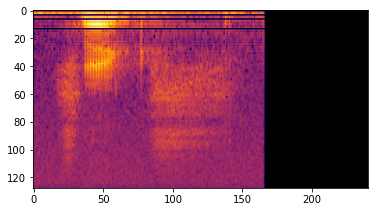

In [36]:
spectrogram, label = next(iter(train_data))
print(spectrogram.shape)
plt.imshow(spectrogram[0], cmap = 'inferno')

In [22]:
# Create our data loaders, for the first pass we wont worry about the validation portion of the data.
train_loader = DataLoader(train_data, batch_size=500, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=True)
new_speaker_loader = DataLoader(new_speaker_test_data, batch_size = 500, shuffle = True)

We need to normalize our data for training the model, mostly we need the data to fall on both sides of 0 so the gradients wont be locked in in a positive manner. we will accomplish this by setting a baseline mean of all the spectrograms and then subtract that mean during the training process from the input. This will accomplish our goal of shifting the domain of the data to both sides of 0.

In [86]:
temp_img = 0
for img, label in tqdm(train_loader):
    temp_img += img.mean(dim=0)
div = len(train_data)/train_loader.batch_size
mean_img = (temp_img/div).float().to(device)

100%|██████████| 40/40 [00:37<00:00,  1.06it/s]


In [25]:
mean_img

tensor([[[-100.2557, -100.2557, -100.2557,  ..., -100.2557, -100.2557,
          -100.2557],
         [ -43.0144,  -40.6133,  -40.6479,  ..., -100.1491, -100.1898,
          -100.2323],
         [ -35.6872,  -33.2833,  -33.3179,  ..., -100.1348, -100.1799,
          -100.2282],
         ...,
         [ -64.6098,  -64.1701,  -64.1773,  ..., -100.1942, -100.2143,
          -100.2397],
         [ -65.7801,  -65.4677,  -65.4612,  ..., -100.1950, -100.2158,
          -100.2402],
         [ -66.9576,  -66.8499,  -66.8665,  ..., -100.1963, -100.2174,
          -100.2399]]], device='cuda:0')

## Model Design
We will be employing a design that is simple in nature and that I believe will match the data in complexity. It will consist of 2 layers of 2d Convolution moving in large strides, with relatively large kernels, followed by a linear layer and finally a softmax layer.

Rationale:
1. The 2d Convolutions should prove very effective at capturing the relationships between the 2 dimensional layout of our date (the third dimension being the values held in each cell) much like convolutions are used in image based nueral networks.
2. The linear layer will be how we reduce the dimension of the last convolution down to the number of output classes, this will provide alot of points for our gradient descent process to update.
3. Finally the softmax layer is added as we look forward to the need to construct a probability distribution for our classification in the nanopore space. It would be better to know now that the softmax is not working with this setup before developing the model further for nanopore data. Although strictly it is likely not necessary for this current model and application.

In [98]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.ConvNet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels = 10, kernel_size = 7, stride = 3),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Conv2d(in_channels=10, out_channels = 10, kernel_size = 5, stride = 2),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Flatten(),
            nn.Linear(38*19*10, 10),
#            nn.Dropout(p = 0.5),
#            nn.Softmax(dim=1)
# Softmax reduced performance significantly and will take further research to implement correctly
        )
        
    def forward(self, x):
        x = self.ConvNet(x)
        return(x)

To correct the earlier statement, we will not be using softmax because it reduced classification performance dramatically. It will require further research to determine the proper implemenation of softmax in this situation because it seems that theoretically it should be a perfect candidate for an output layer for this problem.

In [99]:
model = CNN().to(device)
print(model)

CNN(
  (ConvNet): Sequential(
    (0): Conv2d(1, 10, kernel_size=(7, 7), stride=(3, 3))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(10, 10, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=7220, out_features=10, bias=True)
  )
)


## Optimizer Selection and Loss Function
I am going to borrow heavily from work with image classification and the use of CrossEntropyLoss as well as Adam optimizer. Those both have served me well with image classification and considering the similarity between the problems and the model architecture I don't have a reason to believe that they wont work well in this situation. I will rexamine their role if the model proves ineffectual.

In [100]:
model_loss = nn.CrossEntropyLoss()
model_optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## Training
Training the model will be an iterive process relying on two similar functions the train model and test model functions. Both will load batches from the data loader, compute our mean shift of the X values, predict based on the exisitng model and calculate our losses. The training model will include a second phase where the model is updated based on those weights. 

Each of these models will return an average loss metric as well as an accuracy score for the epoch.

In [101]:
def train_model(model, dataloader, model_loss, optimizer, device, mean):
    total_loss = 0
    total_correct = 0
    model.train()
    
    #Load data from the data loader in batches
    for X,y in dataloader:
        X = X.to(device)
        X = (X - mean) #Mean shift
        y = y.to(device)
        prediction = model(X)
        loss = model_loss(prediction, y.long())
        total_loss += loss.item()
        total_correct += (prediction.argmax(1) == y).sum().item()
        
        #Back propogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    size = len(dataloader.dataset)
    avg_loss = loss/size
    score = total_correct/size
    return(avg_loss, score)

def test_model(model, dataloader, model_loss, device, mean):
    total_loss = 0
    total_correct = 0
    model.eval() #No gradient calculation required
    for X, y in dataloader:
        X = X.to(device)
        X = X - mean
#        print(X)
#        print(y)
        y = y.to(device)
        prediction = model(X)
        loss = model_loss(prediction, y.long())
        total_loss += loss.item()
        total_correct += (prediction.argmax(1) == y).sum().item()
        
    size = len(dataloader.dataset)
    avg_loss = total_loss/size
    score = total_correct/size
    return(avg_loss, score)

In [102]:
train_losses, train_scores, test_losses, test_scores = [], [], [], []
new_speaker_test_scores, new_speaker_test_losses = [], []
for epoch in tqdm(range(25)):
#    print('Epoch:', epoch)
    train_loss, train_score = train_model(model, train_loader, model_loss, model_optimizer, device, mean_img)
    test_loss, test_score = test_model(model, test_loader, model_loss, device, mean_img)
    new_speaker_test_loss, new_speaker_test_score = test_model(model, new_speaker_loader, model_loss, device, mean_img)
    train_losses.append(train_loss)
    train_scores.append(train_score)
    test_losses.append(test_loss)
    test_scores.append(test_score)
    new_speaker_test_losses.append(new_speaker_test_loss)
    new_speaker_test_scores.append(new_speaker_test_score)


100%|██████████| 25/25 [20:36<00:00, 49.47s/it]


In [103]:
#I'm not entirely sure why, but the train_losses needed to be decoupled from the gpu, but the test losses did not.
#This could be from the gradients not being calculated in the test function

train_losses = [x.cpu().detach().numpy() for x in train_losses]
#test_losses = [x.cpu().detach().numpy() for x in test_losses]
type(test_losses[0])

float

## Analysis:
We are going to be looking for an indication that our model found the global minima in this data set and that the testing accuracy and losses confirmed this global minima. Since our dataset is very clean, our hope is that the accuracy will be exceptionally high for our test data.

Additionally for our model to be useful the new speaker test loss needs to show indications of approaching the level of our normal test loss. This would show that our model is well suited to extropolate to new situations that don't match the training data perfectly.

,Train Losses,Test Losses,New Speaker Test Losses
0,0.000021,0.000678,0.000844
1,0.000009,0.000251,0.000397
2,0.000013,0.000156,0.000335
3,0.000007,0.000141,0.000271
4,0.000005,0.000093,0.000191


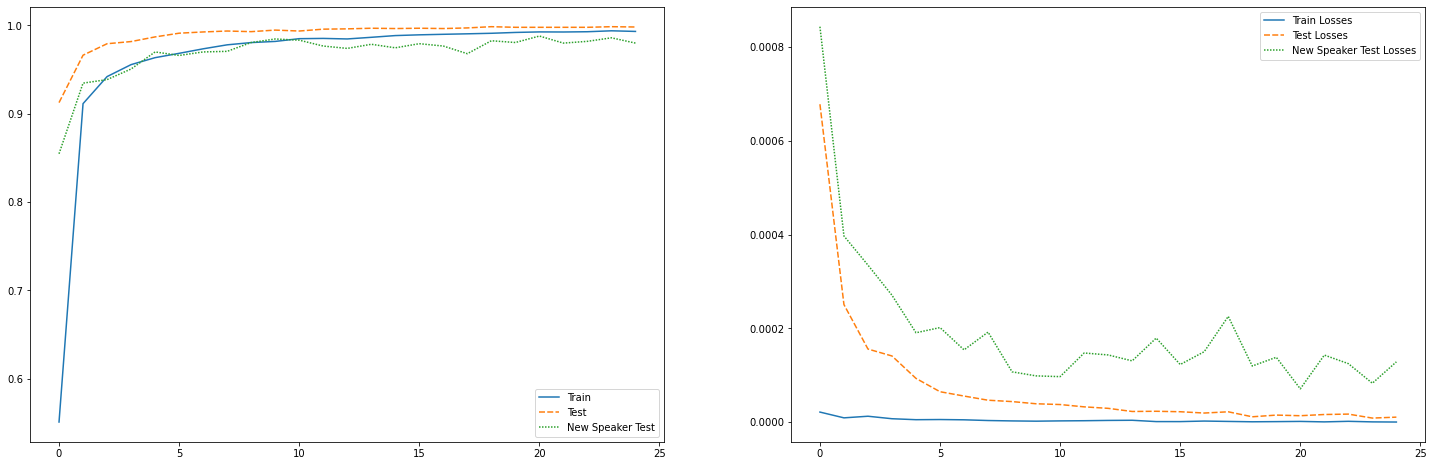

In [104]:
results = pd.DataFrame()
results["Train"] = train_scores
results["Test"] = test_scores
results["New Speaker Test"] = new_speaker_test_scores

losses = pd.DataFrame()
losses["Train Losses"] = train_losses
losses["Train Losses"] = losses["Train Losses"].apply(float)
losses["Test Losses"] = test_losses
losses["New Speaker Test Losses"] = new_speaker_test_losses
fig, axs = plt.subplots(1,2, sharex=True, figsize = (25, 8))
#axs[0] = sns.lineplot(train_losses)
axs[0] = sns.lineplot(data = results, ax=axs[0])
axs[1] = sns.lineplot(data = losses, ax=axs[1])
losses.head()

The data supports our model having found a global minima, while there is some fluctuation around the 10-20 epoch range, it settles by the final epoch and gives a very good final loss value for both test cases.

Additionally the accuracy of our model is acceptable, and with 10 classes accuracy is a pretty good indication of performance over f1, recall, and precision.

Overall I am satisfied with the complexity of the model in comparisson to the results. The only alteration I would like to make to the architecture is figuring out how to properly implement the softmax output layer. Then I believe the model could truly perform at a peak level.

## Conclusion:
Our data supports the conclusion that using spectrograms and 2d convolutional neural networks will be a good candidate moving forward to using speech to text strategies to classify tRNA modifications from ionic current data. 

Specifically the ability to classify into 10 distinct classes with high accuracy is a useful characteristic for the next steps. Another question that this poses is what extra steps wil be required to get the ionic current data transformed into an audiowave like file. Some additional research has shown other similar problems (ECG readings) utilizing the spectrogram for classification tasks. This seems to confirm the hypothesis that spectrograms appear to be a good candidate for moving forward.

First however the softmax issue will need to be resolved and implemented. A properly functioning softmax would allow us to include a threshold at which we could label tRNA modifications that are novel to the training set and flag them for further research.

One of the major hurdles faced in this project will be the construction of a training data set. Since most sequencing currently focuses on the 4 primary nucleotides and not on the identification of short RNA modifications there isn't a prexisting training set.

## References:
### Audio File Structure and Theory
1. https://en.wikipedia.org/wiki/Sampling_(signal_processing)
2. https://www.videoproc.com/resource/wav-file.htm
3. https://pnsn.org/spectrograms/what-is-a-spectrogram
4. https://pytorch.org/audio/stable/functional.html#torchaudio.functional.melscale_fbanks

### Speech to Text Deep Learning
1. https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch/
2. https://www.kaggle.com/code/jokekling/pytorch-study-audio
3. https://www.isca-speech.org/archive/pdfs/interspeech_2021/chen21i_interspeech.pdf

### Pytorch Specific Issues
1. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
2. https://pytorch.org/vision/stable/datasets.html
3. https://pythonguides.com/pytorch-dataloader/ 

### Nanopore Sequencing:
1. https://www.sciencedirect.com/topics/neuroscience/nanopore-sequencing
2. https://www.washington.edu/news/2013/10/15/nanopore-sequencing-technology-lands-licensing-deal/
3. https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.researchgate.net%2Fprofile%2FAnton_Henssen%2Fpublication%2F346026569%2Ffigure%2Ffig5%2FAS%3A963962795458577%401606838048670%2FNanopore-sequencing-characterizes-DNA-methylation-on-MYCN-amplicons-a-Schematic-of.png&f=1&nofb=1